# Course Machine Learning for Particle Physicists
##  PhD course Spring 2020
## Example II : Neural Networks
###  by Veronica Sanz (Universitat de Valencia/ IFIC)


In [0]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
# bigger fonts
plt.rcParams['font.size'] = 18

### Import keras bits and pieces from tensorflow

In [0]:
# if you have a recent version of tensorflow, keras is included
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop

![MNIST](https://peltarion.com/static/fashion-mnist_long.png "MNIST")



In [0]:
# the data, split between train and test sets
(x_train, y_train), (x_valtest, y_valtest) = mnist.load_data()
len(y_train)#y train = labels
len(x_train) #x train = images
len(y_valtest)

10000

In [0]:
# demo the effect of noisy data
#x_train = (x_train/5 + np.random.poisson(200, size=x_train.shape)).clip(0, 255)
#x_valtest = (x_valtest/5 + np.random.poisson(200, size=x_valtest.shape)).clip(0, 255)

In [0]:
# if we wanted to test our model on limited data,
# we could reduce the amount of training data like this...
#idx = np.random.choice(len(x_train), size=len(x_train)//100)
#x_train = x_train[idx]
#y_train = y_train[idx]

### Usually, one splits the data between training, test and validation

#### Training Dataset: 
The sample of data used to fit the model
#### Validation Dataset: 
The sample of data used to provide an unbiased evaluation of a model fit, we use this data to fine-tune the model hyperparameters 
#### Test Dataset:
The sample of data used to provide an unbiased evaluation of a final model fit 


So it is useful to learn how to split the data (using sklearn)

![split](https://miro.medium.com/max/1552/1*Nv2NNALuokZEcV6hYEHdGA.png "split")

In [0]:
from sklearn.model_selection import train_test_split
x_test, x_val, y_test, y_val = train_test_split(x_valtest, y_valtest, test_size=0.5)
#divided valtest into equal sets of 5k 


We explore the effect of train_test_split

In [0]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [0]:
x_test.shape, y_test.shape

((5000, 28, 28), (5000,))

In [0]:
x_val.shape, y_val.shape

((5000, 28, 28), (5000,))

### Take a look at the data

You should always carefully examine any new dataset.
This dataset is already curated, but in real-life situations you will spend **a lot of time** trimming and preparing the data

class = 1


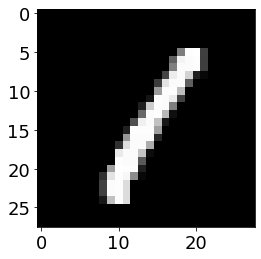

In [0]:
i = 3
plt.imshow(x_train[i], cmap='gray')
print('class =', y_train[i])


class = 8


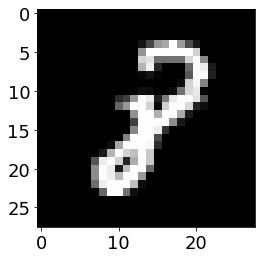

In [0]:
i = 4139
plt.imshow(x_train[i], cmap='gray')
print('class =', y_train[i])

### Prepare the data

Remember the y variables (outputs) are in classes from 0 to 9, e.g. y in the previous plot is class = 8

**One-hot** changes this simple number (class) to a matrix which contains 0 for all the entries except for 8

This is simply implemented using keras utilities

In [0]:
# convert class vectors to "one-hot" class matrices
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

In [0]:
y_train[i]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

Now the inputs, the images:

Take the 28X28 bins of images (=784) with levels of gray 0 to 255 and

flatten them in an array and re-scale the content (intensity of gray) from 0 to 1

In [0]:
def process_data(x):
    x = x.reshape(-1, 784)
    x = x.astype('float32')
    x /= 255
    return x

In [0]:
x_train = process_data(x_train)
x_test = process_data(x_test)
x_val = process_data(x_val)

In [0]:
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_val.shape[0], 'validation samples')

60000 train samples
5000 test samples
5000 validation samples


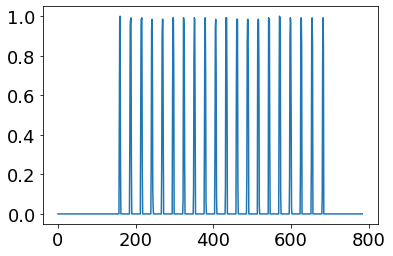

In [0]:
plt.plot(x_train[3])


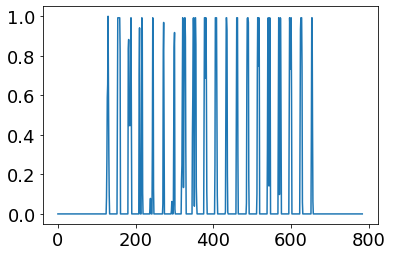

In [0]:
plt.plot(x_train[4139])

## Let's start with a simple NN: fully connected NN

### Build the NN

In [0]:
# Sequential means you can build a DNN layer by layer
fcmodel = Sequential()
# Dense has as arguments: 
#  number of neurons, type of activation function, and the input needs to match the output of the previous layer
#  input_shape=(N_features,) where N_features = 28*28
fcmodel.add(Dense(32, activation='relu', input_shape=(784,)))
# we add a second layer
fcmodel.add(Dense(32, activation='relu'))
# could include dropout, regularisation, ...
fcmodel.add(Dense(num_classes, activation='softmax'))

In [0]:
fcmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 26,506
Trainable params: 26,506
Non-trainable params: 0
_________________________________________________________________


Next, we choose the loss function according to which we will train the DNN 

For classification problems, this is usually the cross-entropy, and since the output data was cast in categorical
form, we choose the categorical_crossentropy defined in Keras’ losses module 

To optimize the weights of the net, we use SGD (Stochastic Gradient Descent) or other typical choices are RMSprop or Adam

The parameters for the optimizer, such as lr (learning rate) or momentum are passed using the corresponding optional arguments of the SGD() function

In [0]:
fcmodel.compile(loss='categorical_crossentropy',
                optimizer=RMSprop(),
                metrics=['accuracy'])

### Train the NN

The **batch size** defines the number of samples that will be propagated through the network.

We have 60000 training samples and we set up a batch_size equal to 32. The algorithm takes the first 32 samples from the training dataset and trains the network. Next, it takes the second batch and trains the network again, and keep with this procedure until we have propagated all samples through of the network. 

**Training epochs** defines the number times that the learning algorithm will work through the entire training dataset.


In [0]:
batch_size = 32
epochs = 20

In [0]:
# training the NN
history = fcmodel.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(x_val, y_val))

Epoch 1/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3502 - accuracy: 0.9001 - val_loss: 0.2131 - val_accuracy: 0.9380
Epoch 2/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1752 - accuracy: 0.9492 - val_loss: 0.1569 - val_accuracy: 0.9522
Epoch 3/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1404 - accuracy: 0.9592 - val_loss: 0.1435 - val_accuracy: 0.9578
Epoch 4/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1217 - accuracy: 0.9643 - val_loss: 0.1443 - val_accuracy: 0.9610
Epoch 5/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1107 - accuracy: 0.9680 - val_loss: 0.1383 - val_accuracy: 0.9638
Epoch 6/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1022 - accuracy: 0.9706 - val_loss: 0.1396 - val_accuracy: 0.9630
Epoch 7/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0958 - accuracy: 0.9728 - val_loss: 0.1365 - val_accuracy:

In [0]:
# in principle, we should not look at the score for this set of data
# until we have finished tuning our model
score = fcmodel.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.17762769758701324
Test accuracy: 0.9688000082969666


In [0]:
def histplot(history):
    hist = pd.DataFrame(history.history)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    hist.plot(y=['loss','val_loss'], ax=ax1)
    min_loss = hist['val_loss'].min()
    ax1.hlines(min_loss, 0, len(hist), linestyle='dotted',
               label='min(val_loss) = {:.3f}'.format(min_loss))
    ax1.legend(loc='upper right')
    hist.plot(y=['accuracy','val_accuracy'], ax=ax2)
    max_acc = hist['val_accuracy'].max()
    ax2.hlines(max_acc, 0, len(hist), linestyle='dotted',
               label='max(val_accuracy) = {:.3f}'.format(max_acc))
    ax2.legend(loc='lower right', fontsize='large')

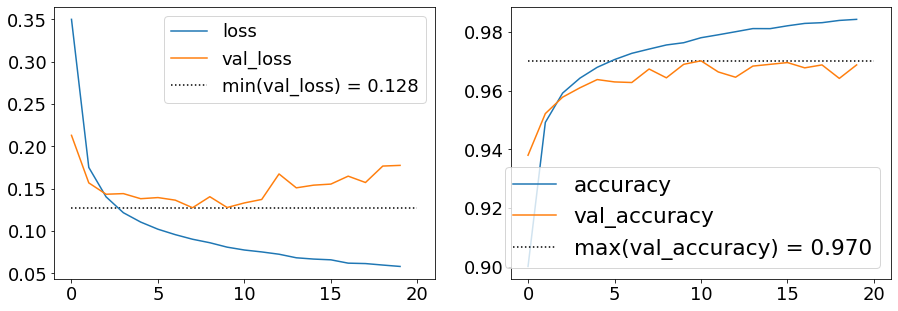

In [0]:
histplot(history)

## Now let's use a Convolutional Neural Network (CNN)

### We need to reshape the data  

In [0]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)

In [0]:
x_train.shape

(60000, 28, 28, 1)

###  Construct the network

In [0]:
# a fairly small network for speed
cnnmodel = Sequential()
cnnmodel.add(Conv2D(8, (3, 3), activation='relu', input_shape=(28, 28, 1)))
cnnmodel.add(MaxPooling2D((3, 3)))
cnnmodel.add(Conv2D(16, (3, 3), activation='relu'))
cnnmodel.add(MaxPooling2D((2, 2)))
cnnmodel.add(Flatten())
cnnmodel.add(Dense(num_classes, activation='softmax'))
# could include dropout, regularisation, ... which would make the learning more robust. No need if the learning is converging

In [0]:
cnnmodel.compile(loss='categorical_crossentropy',
                optimizer=RMSprop(),
                metrics=['accuracy'])

In [0]:
cnnmodel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 16)          1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 144)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1450      
Total params: 2,698
Trainable params: 2,698
Non-trainable params: 0
____________________________________________________

### Train the CNN

In [0]:
history = cnnmodel.fit(x_train, y_train,
                       batch_size=batch_size, 
                       epochs=epochs,
                       verbose=1,
                       validation_data=(x_val, y_val))

Epoch 1/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3886 - accuracy: 0.8856 - val_loss: 0.1250 - val_accuracy: 0.9614
Epoch 2/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1290 - accuracy: 0.9607 - val_loss: 0.0907 - val_accuracy: 0.9694
Epoch 3/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0986 - accuracy: 0.9694 - val_loss: 0.0739 - val_accuracy: 0.9748
Epoch 4/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0834 - accuracy: 0.9740 - val_loss: 0.0714 - val_accuracy: 0.9756
Epoch 5/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0746 - accuracy: 0.9774 - val_loss: 0.0695 - val_accuracy: 0.9754
Epoch 6/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0678 - accuracy: 0.9784 - val_loss: 0.0580 - val_accuracy: 0.9790
Epoch 7/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0620 - accuracy: 0.9810 - val_loss: 0.0501 - val_accuracy:

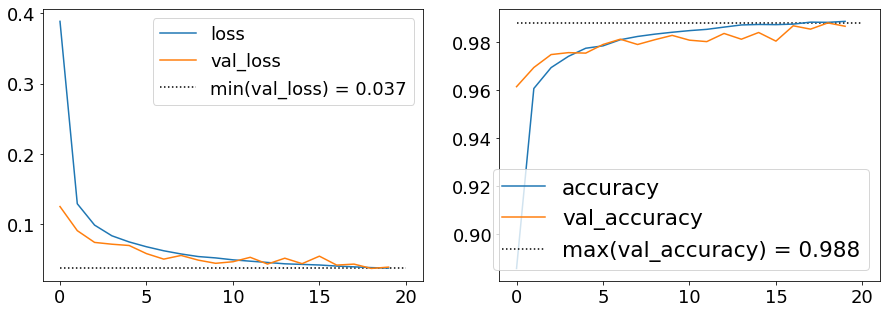

In [0]:
histplot(history)

In [0]:
from keras.preprocessing import image
img = x_test[130]
test_image = image.img_to_array(img)
test_image = np.expand_dims(test_image, axis=0)
prediction = cnnmodel.predict(test_image)
print(prediction)




In [0]:
# save weights for reinitialising below
cnnmodel.save_weights('/tmp/cnnmodel_init_weights.tf')

## Data augmentation

Data augmentation is a technique to artificially create new training data from existing training data by rotating, obscuring or other transformations in the original data. 

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=20.0,
    zoom_range=0.05
    )

#datagen.fit(x_train)  # only required if normalizing

In [0]:
gen = datagen.flow(x_train, y_train, batch_size=1)

label = 7


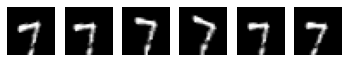

In [0]:
# run this several times to see more augmented examples
i = 9
fig, axarr = plt.subplots(1, 6)
for ax in axarr:
    img = gen[i][0][0, : , :, 0]
    ax.imshow(img, cmap='gray');
    ax.axis('off')
print('label =', gen[i][1][0].argmax())

In [0]:
# Reinitialise model
cnnmodel.load_weights('/tmp/cnnmodel_init_weights.tf')

In [0]:
cnnmodel.compile(loss='categorical_crossentropy',
                 optimizer=RMSprop(),
                 metrics=['accuracy'])

In [0]:
# fits the model on batches with real-time data augmentation:
# the accuracy continues to (slowly) rise, due to the augmentation
# it may be convenient to deepen the NN, adding more layers, so it can handle it
history = cnnmodel.fit_generator(datagen.flow(x_train, y_train, batch_size=50), 
                                 epochs=3,
                                 verbose=1,
                                 validation_data=(x_val, y_val))

Epoch 1/3
 735873/Unknown - 9392s 13ms/step - loss: 0.0653 - accuracy: 0.9812

In [0]:
histplot(history)


## THINGS to play with

1.   Change the NN architecture
2.   Change the training epochs, regularisation, dropout rate
3.   Change the train/test splitting
4.   Change the transformations in data augmentation. Is there a limitation?
5.   Use other datasets to classify images





